### Random Forests and Extra Random Trees

A few examples are reproduced or adapted from

https://github.com/jakevdp/PythonDataScienceHandbook

The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). 


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#This is an auxiliary function that can help us visualize trees.

def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Let's make up some data:

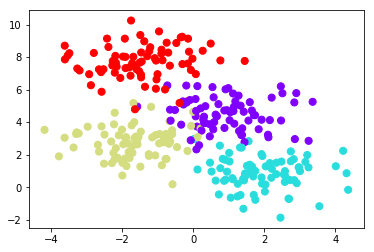

In [9]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

We can use a decision tree classifier and change the max_depth (corresponding to the maximum number of splits) from 1 to 6 to ask scikit to fit our data with 1, 2... 6 splits.

/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


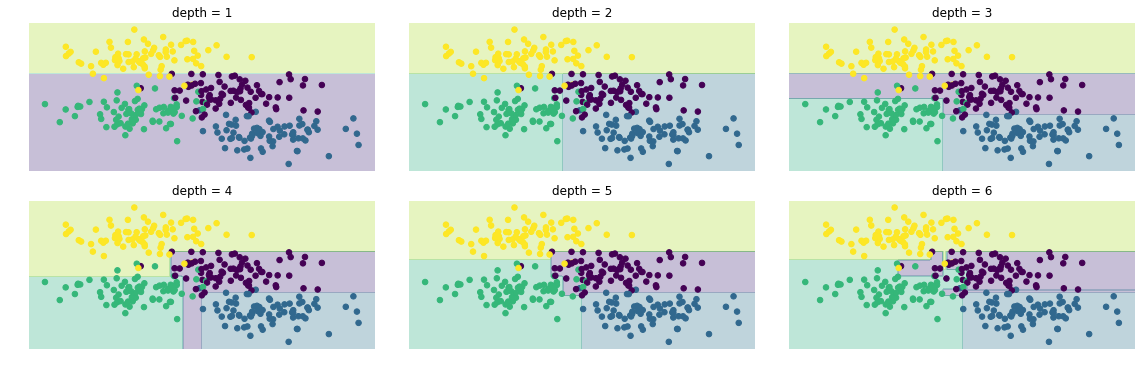

In [4]:
from sklearn.tree import DecisionTreeClassifier
        
fig, ax = plt.subplots(2, 3, figsize=(16, 6))

ax = ax.ravel()
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

#X, y = make_blobs(n_samples=300, centers=4,
#                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 7)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))


You can see that there are some weird little regions when depth > 3: a sign of overfitting.

Let's do a 5 fold cross validation with our decision tree to get an idea of the performance and whether we are suffering from high bias or high variance.

In [2]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import metrics

In [6]:
model = DecisionTreeClassifier()

In [7]:
predicted = cross_val_predict(model, X, y, cv=StratifiedKFold(n_splits=8))

Let's take a look at our scores. Note: there are four classes, so to use precision or recall we would need to define them on a class-by-class basis. We'll use accuracy for simplicity.

In [8]:
cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=6)).mean()

0.9027777777777778

In [9]:
cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=6)).std()

0.03919371498544674

Scores are pretty decent (accuracy of around 90%, and this is a balanced data set for which accuracy is meaningful), so we know bias is low.

#### Let's check for high variance by looking at some train test splits. I am going to define a function that looks at train/test scores for a few random splits and reports their average and standard deviation; you can use this function whenever you want to check for high variance.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def checktraintest(X, y, model, ntrials =5, test_size = 0.2):

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size, random_state=i)
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)

        scores_test[i] = (metrics.accuracy_score(y_test,pred_test))
        scores_train[i] =(metrics.accuracy_score(y_train,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))

In [12]:
checktraintest(X,y,DecisionTreeClassifier())

Training scores 1.0 +- 0.0
Test scores 0.9166666666666667 +- 0.018257418583505516


#### Agh! The ugly face of high variance has shown up. To fix it, we can either play with parameters like max_depth, or upgrade to a randomized method.

#### Let us now switch to a Random Forest Classifier and see what happens.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

Let's do the same thing as above but using a Random Forest with standard parameters.

In [16]:
checktraintest(X,y,RandomForestClassifier(n_estimators = 20))

Training scores 0.9991666666666668 +- 0.001666666666666661
Test scores 0.93 +- 0.019436506316150983


We can see some improvement already: slightly higher test scores and a smaller gap between train and test scores. 

#### We can do better by playing with the parameters of the RF: let's take a look at them and discuss.

In [17]:
print(RandomForestClassifier())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### Typically, when we optimize RFs we play with: n_estimators, min_samples_leaf, min_samples_split, max_depth, and max_features.

More trees (increasing n_estimators) are always better but usually you get to a plateau after a certain number (and of course, it takes more time).

max_features is a good parameter to play with (it's the size of the subset of random features used to create splits) but in this data set there are only two features so not much fun.

min_samples_split and min_samples_leaf are the minimum amount of examples that need to be in each split/leaf node. 

Setting one of these parameters to a higher number (with respect to their default values of 2/1 respectively) is a great way to avoid overfitting.

Max_depth is the maximum number of splits in a tree. This is also a good parameter to tune to avoid overfitting.

You can find a more detailed description of these parameters in my notebook for my Strata 2018 tutorial:

https://github.com/vacquaviva/Strata2018

In [23]:
checktraintest(X,y,RandomForestClassifier(n_estimators=50))

Training scores 1.0 +- 0.0
Test scores 0.93 +- 0.02211083193570267


In [27]:
checktraintest(X,y,RandomForestClassifier(n_estimators=20,max_features=1))

Training scores 0.9983333333333334 +- 0.002041241452319308
Test scores 0.9233333333333332 +- 0.016996731711975938


In [28]:
checktraintest(X,y,RandomForestClassifier(n_estimators=20, min_samples_leaf= 5))

Training scores 0.9508333333333334 +- 0.008079466429027236
Test scores 0.9466666666666667 +- 0.032317865716108826


In [29]:
checktraintest(X,y,RandomForestClassifier(n_estimators=20, min_samples_split= 10))

Training scores 0.9558333333333333 +- 0.007728015412913104
Test scores 0.9400000000000001 +- 0.030912061651652334


In [32]:
checktraintest(X,y,RandomForestClassifier(n_estimators=20, max_depth= 3))

Training scores 0.9516666666666665 +- 0.00424918292799402
Test scores 0.95 +- 0.029814239699997178


Of course a proper parameter optimization should be done with a GridSearch and nested cross validation.

### How about Extra Random Trees?

The main difference between RFs and ERTs is the way data and features are randomized. 

In Random Forests, we build many trees on slightly different subselections of data (bootstrap), and we select a random set of features for each tree on which we decide the splits. 

In ERTs, we (usually) don't do the bootstrap of data, but we select a random set of features for each tree on which we decide the splits and we also use a random threshold for the splits (not the best possible value).

Parameters are pretty similar for these two algorithms.

In [7]:
print(ExtraTreesClassifier())

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [10]:
checktraintest(X,y,ExtraTreesClassifier(n_estimators = 20))

Training scores 1.0 +- 0.0
Test scores 0.9133333333333333 +- 0.012472191289246464


Out of the box, they perform a bit worse than RFs.

In [11]:
checktraintest(X,y,ExtraTreesClassifier(n_estimators=20,min_samples_leaf=5))

Training scores 0.9333333333333332 +- 0.0069721668877839385
Test scores 0.93 +- 0.022110831935702666


In [15]:
checktraintest(X,y,ExtraTreesClassifier(n_estimators=20,max_depth=5))

Training scores 0.9483333333333335 +- 0.007728015412913104
Test scores 0.9400000000000001 +- 0.024944382578492935


Playing with features makes them comparable in performance with RFs. For more complicated data sets with many features and high risk of overfitting, ERTs are often better.

#### One important feature of RF and ERTs is that they can be used both for classification and regression.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [17]:
def checktraintestreg(X, y, model, ntrials =5, test_size = 0.2):

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size, random_state=i)
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)

        scores_test[i] = (metrics.r2_score(y_test,pred_test))
        scores_train[i] =(metrics.r2_score(y_train,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))

In [18]:
checktraintestreg(X,y,RandomForestRegressor(n_estimators = 20))

Training scores 0.9678090120937959 +- 0.004079685633708632
Test scores 0.8103741458253294 +- 0.048061054198940224


This looks scary but keep in mind that the r2 score IS NOT a percentage! 

In [26]:
checktraintestreg(X,y,RandomForestRegressor(n_estimators=20,max_depth=5,min_samples_leaf=8))

Training scores 0.8418080201365961 +- 0.010579300822276693
Test scores 0.7946034056498412 +- 0.03778359056910181


As usual, more estimators help and having a larger value for min_sample_leaf helps with the high variance issue by reducing the gap between train and test scores. 

But which one is better, classifier or regressor? It really depends on the problem. We can take a look at the true vs predicted values in a graphical way:

In [27]:
predicted_RFC = cross_val_predict(RandomForestClassifier(n_estimators=20,min_samples_leaf=5), X, y, cv=StratifiedKFold(n_splits=5))

In [28]:
predicted_RFR = cross_val_predict(RandomForestRegressor(n_estimators=20,min_samples_leaf=5), X, y, cv=StratifiedKFold(n_splits=5))

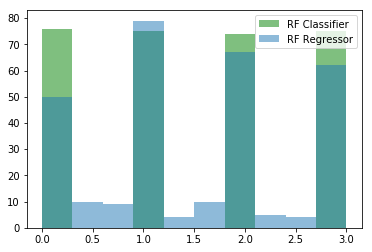

In [29]:
plt.hist(predicted_RFC,alpha = 0.5, color='green',label = 'RF Classifier')
plt.hist(predicted_RFR,alpha = 0.5, label = 'RF Regressor')
plt.legend();

Tricks: 

1) Look at input data, if they really look like classes then you should use a classifier.

2) You can't compute the accuracy if the target is continuous variable, but you can compute the r2 score if the target is a class!

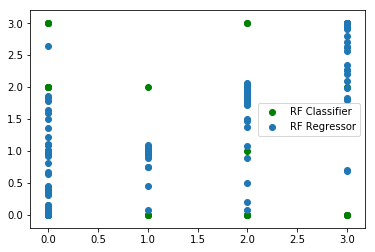

In [30]:
plt.scatter(y,predicted_RFC, color = 'green', label = 'RF Classifier')
plt.scatter(y,predicted_RFR,label = 'RF Regressor')
plt.legend();

In [31]:
checktraintestreg(X,y,RandomForestClassifier(n_estimators=20,min_samples_leaf=5))

Training scores 0.8429111487626857 +- 0.023547608538030028
Test scores 0.8042012397520273 +- 0.11711339798948778


In [32]:
checktraintestreg(X,y,RandomForestRegressor(n_estimators=20,min_samples_leaf=5))

Training scores 0.8741594605685021 +- 0.017229095382440867
Test scores 0.8117415184875684 +- 0.0400410008926416


Which one is better? And why?

####  Feature importance: one last *awesome* thing about ensemble methods.

Let us define and fit a model; after the model has been fit, it will have the attribute "feature\_importances\_" that we can use to plot the most important features.

We can't do it for this data set with ony two features, so let's do it on the digits data set instead!

In [33]:
from sklearn.datasets import load_digits
digits = load_digits()
features = digits.data
labels = digits.target

In [34]:
model = RandomForestClassifier(min_samples_leaf=5,n_estimators=20)

After the model has been fit, it will have the attribute "feature\_importances\_"

In [35]:
model.fit(features,labels) #note: this is not doing any train/test split, but fitting the entire data set 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
model.feature_importances_

array([0.        , 0.00166956, 0.0151439 , 0.01070936, 0.0072095 ,
       0.0225667 , 0.00636835, 0.00066629, 0.        , 0.01231406,
       0.02100656, 0.0033193 , 0.00924062, 0.02834112, 0.00602491,
       0.00032941, 0.        , 0.00603107, 0.01907387, 0.03338365,
       0.02741093, 0.05600982, 0.00485771, 0.        , 0.        ,
       0.00695298, 0.04040803, 0.01977503, 0.03363291, 0.02463389,
       0.03728996, 0.        , 0.        , 0.03655873, 0.02796323,
       0.01131105, 0.04444943, 0.01692264, 0.02087587, 0.        ,
       0.        , 0.01747637, 0.04572464, 0.05835236, 0.01969374,
       0.01514345, 0.01338576, 0.        , 0.        , 0.00154548,
       0.01709649, 0.02268734, 0.01100341, 0.01619427, 0.0308017 ,
       0.00204073, 0.        , 0.00144158, 0.01798757, 0.00768168,
       0.02760829, 0.02724621, 0.02933037, 0.00510811])

The code below plots the feature importances.

Feature ranking:
1. feature 43 (0.058352)
2. feature 21 (0.056010)
3. feature 42 (0.045725)
4. feature 36 (0.044449)
5. feature 26 (0.040408)
6. feature 30 (0.037290)
7. feature 33 (0.036559)
8. feature 28 (0.033633)
9. feature 19 (0.033384)
10. feature 54 (0.030802)
11. feature 62 (0.029330)
12. feature 13 (0.028341)
13. feature 34 (0.027963)
14. feature 60 (0.027608)
15. feature 20 (0.027411)
16. feature 61 (0.027246)
17. feature 29 (0.024634)
18. feature 51 (0.022687)
19. feature 5 (0.022567)
20. feature 10 (0.021007)
21. feature 38 (0.020876)
22. feature 27 (0.019775)
23. feature 44 (0.019694)
24. feature 18 (0.019074)
25. feature 58 (0.017988)
26. feature 41 (0.017476)
27. feature 50 (0.017096)
28. feature 37 (0.016923)
29. feature 53 (0.016194)
30. feature 2 (0.015144)
31. feature 45 (0.015143)
32. feature 46 (0.013386)
33. feature 9 (0.012314)
34. feature 35 (0.011311)
35. feature 52 (0.011003)
36. feature 3 (0.010709)
37. feature 12 (0.009241)
38. feature 59 (0.007682)
39. feat

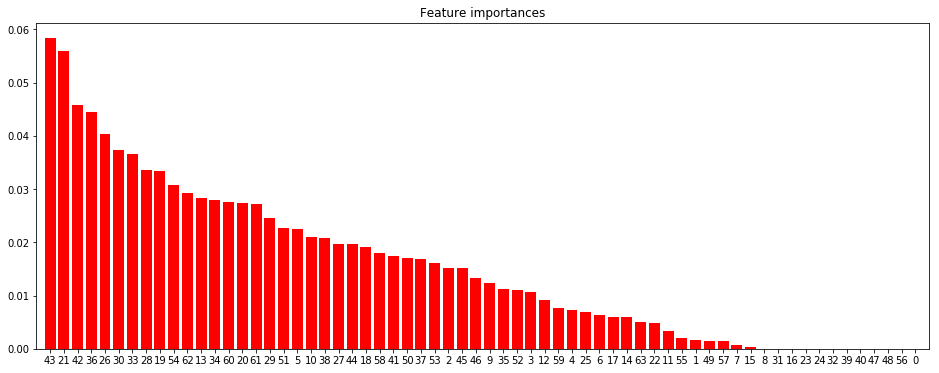

In [37]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,6))
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

How can we select only the most important ones in order to reduce the size of our data set?

In [38]:
from sklearn.feature_selection import SelectFromModel

In [40]:
features.shape

(1797, 64)

In [45]:
featuresel = SelectFromModel(model,threshold=0.03,prefit=True)
features_new = featuresel.transform(features) #note: only features are transformed
print(features_new.shape) 

(1797, 10)


In [41]:
checktraintest(features,labels,RandomForestClassifier(n_estimators=20,min_samples_leaf=5))

Training scores 0.9909533750869868 +- 0.0028523175409769334
Test scores 0.9505555555555555 +- 0.010743933114340964


In [46]:
checktraintest(features_new,labels,RandomForestClassifier(n_estimators=20,min_samples_leaf=5))

Training scores 0.9427974947807932 +- 0.0016701461377870875
Test scores 0.8794444444444445 +- 0.015772299518420442
